In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, InputLayer
from keras.layers import Conv2D, MaxPooling2D

In [3]:
data = pd.read_csv('/content/emergency_classification.csv')
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load images and store it in numpy array
x = []

for img_name in data.image_names:
  img = plt.imread('/content/drive/MyDrive/13th July 2024/images/' + img_name)
  x.append(img)

x = np.array(x)
#y = data.emergency_or_not.values

In [5]:
x.shape

(2352, 224, 224, 3)

In [6]:
y = data['emergency_or_not']
y

0       1
1       1
2       1
3       1
4       1
       ..
2347    0
2348    0
2349    0
2350    0
2351    0
Name: emergency_or_not, Length: 2352, dtype: int64

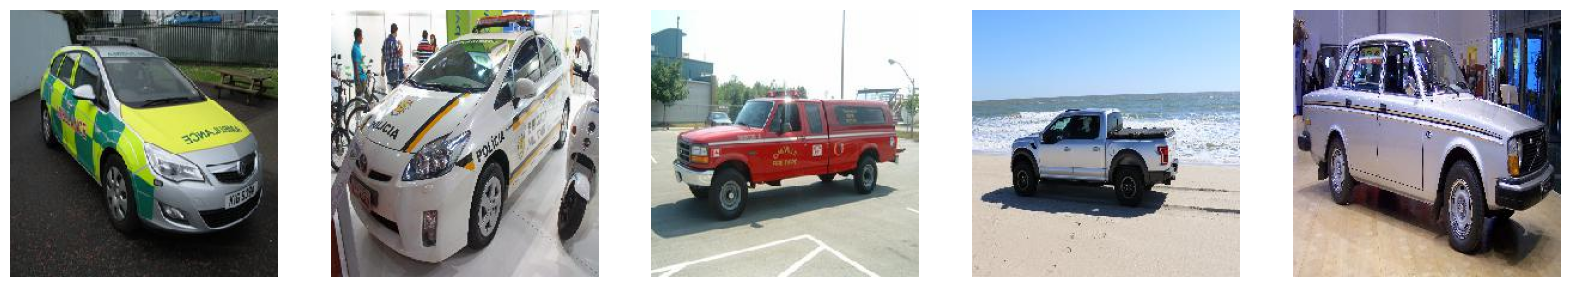

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range(5):
  ax[i].imshow(x[i*400])
  ax[i].axis('off')

In [7]:
x = x/x.max()

In [12]:
x.max()

1.0

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x.astype('float64'), y, test_size=0.3, random_state=42)
print(x_train.shape, x_test.shape)

(1646, 224, 224, 3) (706, 224, 224, 3)


In [15]:
# CNN Model
epochs= 10
batch_size= 128

# create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(7,7), input_shape=(224,224,3), name='conv1'))
model.add(LeakyReLU(name='lrelu1'))
model.add(MaxPooling2D(pool_size=(4,4), name='pool1'))
model.add(Conv2D(32, (7,7), name='conv2'))
model.add(LeakyReLU(name='lrelu2'))
model.add(MaxPooling2D(pool_size=(4,4), name='pool2'))
model.add(Conv2D(32, (7,7), name='conv3'))
model.add(LeakyReLU(name='lrelu3'))
model.add(MaxPooling2D(pool_size=(4,4), name='pool3'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid', name = 'predict'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
trained_model = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Epoch 1/10
13/13 [==============================] - 7s 354ms/step - loss: 0.7157 - accuracy: 0.5881 - val_loss: 0.6535 - val_accuracy: 0.6034
Epoch 2/10
13/13 [==============================] - 2s 189ms/step - loss: 0.6220 - accuracy: 0.6835 - val_loss: 0.6280 - val_accuracy: 0.6445
Epoch 3/10
13/13 [==============================] - 2s 188ms/step - loss: 0.5797 - accuracy: 0.6908 - val_loss: 0.5492 - val_accuracy: 0.7280
Epoch 4/10
13/13 [==============================] - 3s 203ms/step - loss: 0.5111 - accuracy: 0.7533 - val_loss: 0.4895 - val_accuracy: 0.7521
Epoch 5/10
13/13 [==============================] - 2s 189ms/step - loss: 0.4879 - accuracy: 0.7746 - val_loss: 0.4637 - val_accuracy: 0.7635
Epoch 6/10
13/13 [==============================] - 3s 211ms/step - loss: 0.4497 - accuracy: 0.7983 - val_loss: 0.4497 - val_accuracy: 0.8003
Epoch 7/10
13/13 [==============================] - 3s 208ms/step - loss: 0.4216 - accuracy: 0.8044 - val_loss: 0.4258 - val_accuracy: 0.7932
Epoch 

In [13]:
# Attempt 1 : Understanding the Model Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      4736      
                                                                 
 lrelu1 (LeakyReLU)          (None, 218, 218, 32)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 54, 54, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 32)        50208     
                                                                 
 lrelu2 (LeakyReLU)          (None, 48, 48, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 12, 32)        0         
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 32)          5

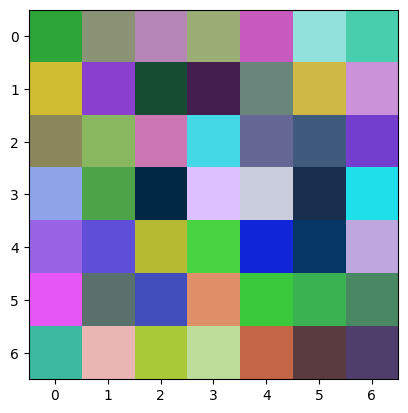

In [16]:
# Attempt 2 - Visualize Filters and Weights
temp = model.get_layer('conv1').get_weights()[0][:,:,:,0]
temp -=temp.min()
# temp = temp - temp.min()
temp /=temp.max()
plt.imshow(temp)
plt.show()

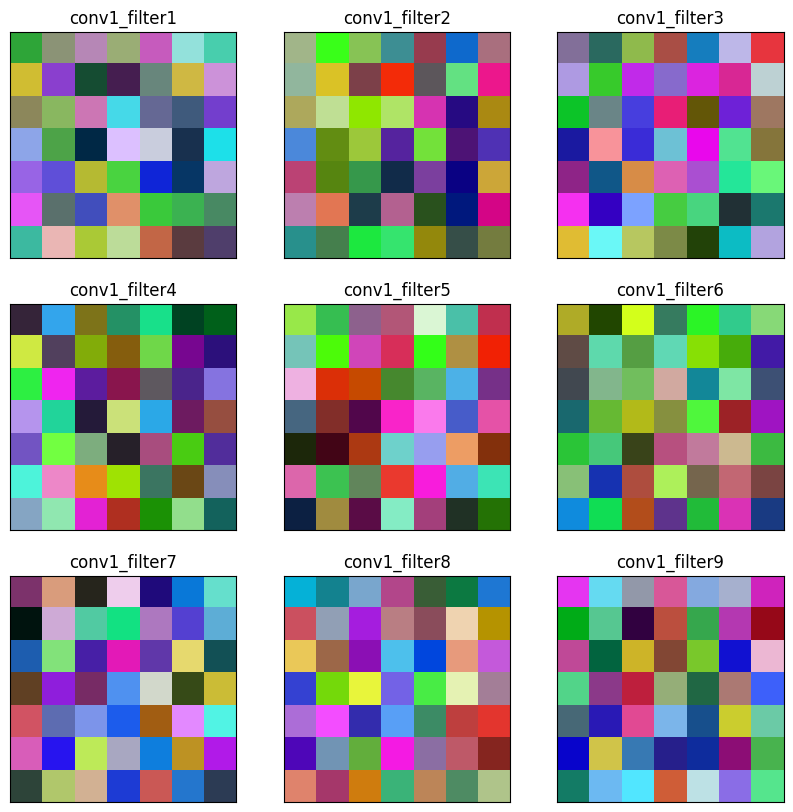

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
filter_no = 1
for i in range(3):
  for j in range(3):
    temp = model.get_layer('conv1').get_weights()[0][:,:,:,filter_no - 1]
    temp -=temp.min()
    temp /=temp.max()
    ax[i][j].imshow(temp)
    ax[i][j].set_title('conv1' + '_filter' + str(filter_no))
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    filter_no +=1

1/1 [==============================] - 0s 258ms/step


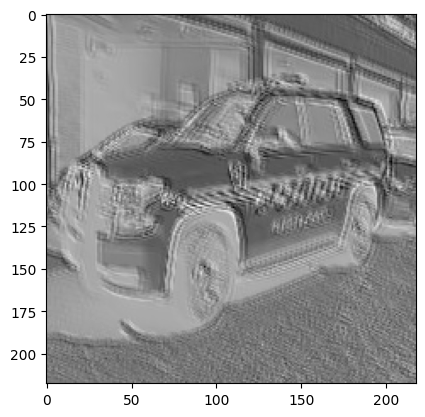

In [19]:
# Attempt 3 : Extract output of Intermediat Neurons/Layers

eg_image_idx = 5
image = x_train[eg_image_idx]
image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv1').output)
intermediate_output = intermediate_layer_model.predict(image)[0,:,:, 0]
plt.imshow(intermediate_output, cmap='gray')

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 90ms/step


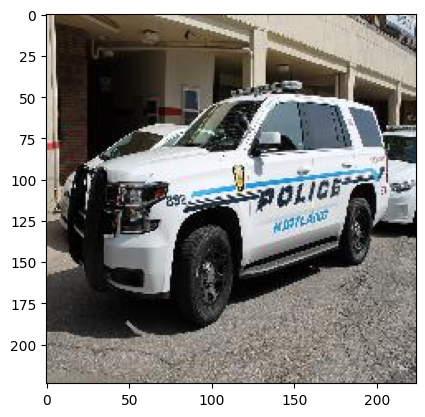

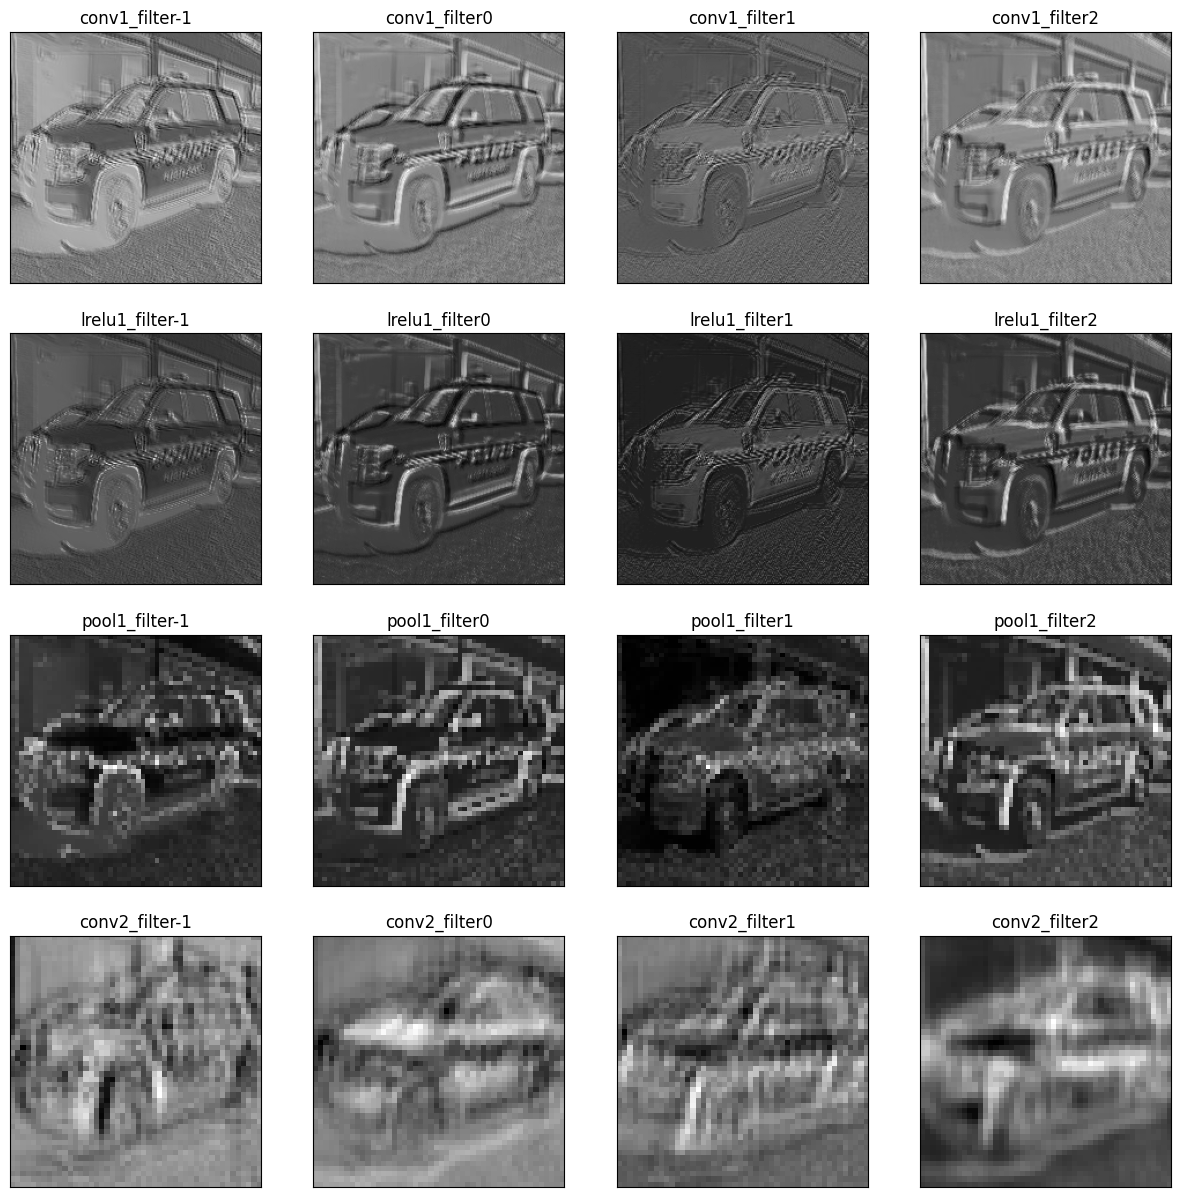

In [20]:
layer_names = ['conv1','lrelu1','pool1','conv2']
outputs = []
eg_image_idx = 5
image = x_train[eg_image_idx]
plt.imshow(image)


image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

for layer_name in layer_names:
  intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
  intermediate_output = intermediate_layer_model.predict(image)
  outputs.append(intermediate_output)

fig, ax = plt.subplots(nrows=len(outputs), ncols=4, figsize=(15,15))

for i in range(len(outputs)):
  for z in range(4):
    ax[i][z].imshow(outputs[i][0,:,:,z], cmap='gray')
    ax[i][z].set_title(layer_names[i] + '_filter' + str(z-1))
    ax[i][z].set_xticks([])
    ax[i][z].set_yticks([])


In [9]:
# Transfer Learning model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50


In [23]:
y

0       1
1       1
2       1
3       1
4       1
       ..
2347    0
2348    0
2349    0
2350    0
2351    0
Name: emergency_or_not, Length: 2352, dtype: int64

In [10]:
y = keras.utils.to_categorical(y)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [25]:
x.min(), x.max()

(0.0, 1.0)

In [15]:
# Load weights of Pretrained Model
base_model = VGG16(weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
base_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

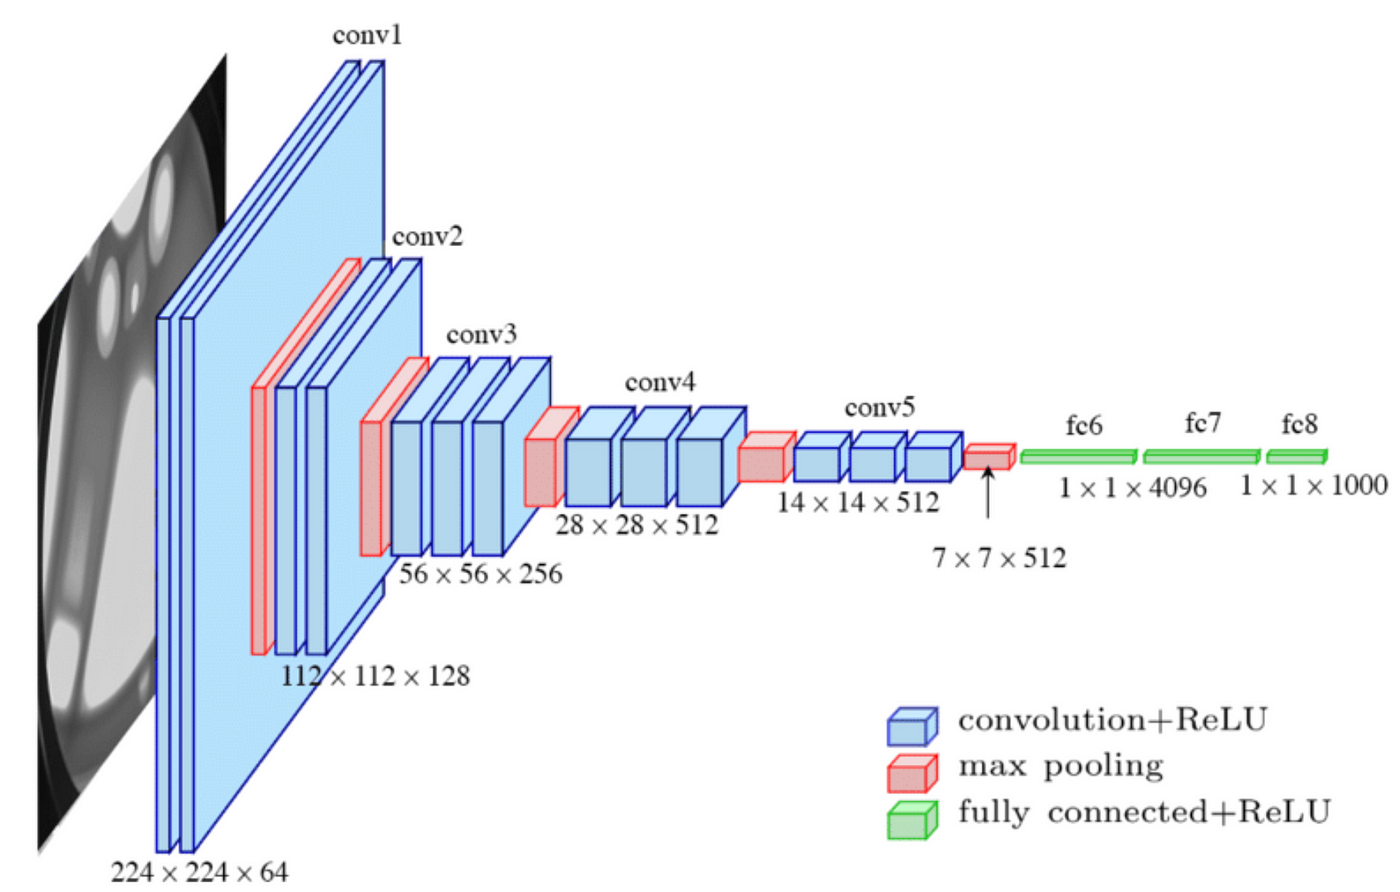

In [12]:
base_model_pred = base_model.predict(x_train)
base_model_pred_valid = base_model.predict(x_test)

23/23 [==============================] - 5s 204ms/step


In [13]:
base_model_pred.shape

(1646, 7, 7, 512)

In [18]:
base_model_pred_valid.shape

(706, 7, 7, 512)

In [ ]:
# Fine Tuning method

In [16]:
base_model_pred = base_model_pred.reshape(1646, 7*7*512)

In [17]:
base_model_pred.shape

(1646, 25088)

In [19]:
base_model_pred_valid = base_model_pred_valid.reshape(706, 7*7*512)

In [20]:
base_model_pred_valid.shape

(706, 25088)

In [21]:
max_val = base_model_pred.max()

In [22]:
base_model_pred = base_model_pred / max_val
base_model_pred_valid = base_model_pred_valid / max_val
base_model_pred.min(), base_model_pred.max()

(0.0, 1.0)

In [26]:
# reate a sequential model
model = Sequential()
model.add(InputLayer((7*7*512)))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25692161 (98.01 MB)
Trainable params: 25692161 (98.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
25088 * 1024 + 1024

25691136

In [27]:
model.fit(base_model_pred, y_train, epochs=10,batch_size=128, validation_data = (base_model_pred_valid, y_test))

Epoch 1/10
13/13 [==============================] - 4s 51ms/step - loss: 0.5522 - accuracy: 0.7418 - val_loss: 0.3889 - val_accuracy: 0.8314
Epoch 2/10
13/13 [==============================] - 0s 25ms/step - loss: 0.2656 - accuracy: 0.8955 - val_loss: 0.2632 - val_accuracy: 0.8952
Epoch 3/10
13/13 [==============================] - 0s 25ms/step - loss: 0.1890 - accuracy: 0.9338 - val_loss: 0.2029 - val_accuracy: 0.9150
Epoch 4/10
13/13 [==============================] - 0s 25ms/step - loss: 0.1246 - accuracy: 0.9605 - val_loss: 0.1828 - val_accuracy: 0.9292
Epoch 5/10
13/13 [==============================] - 0s 23ms/step - loss: 0.0891 - accuracy: 0.9763 - val_loss: 0.1742 - val_accuracy: 0.9320
Epoch 6/10
13/13 [==============================] - 0s 24ms/step - loss: 0.0635 - accuracy: 0.9866 - val_loss: 0.1601 - val_accuracy: 0.9348
Epoch 7/10
13/13 [==============================] - 0s 30ms/step - loss: 0.0469 - accuracy: 0.9921 - val_loss: 0.1612 - val_accuracy: 0.9348
Epoch 8/10
13

In [28]:
# Get Predictions
predictions = model.predict(base_model_pred_valid)
predictions = predictions.reshape(-1,)
predictions_int = predictions >=0.5
predictions_int = predictions_int.astype(int)
predictions_int

23/23 [==============================] - 0s 5ms/step


array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,

In [ ]:
# Summary of Transformation Learning
# 1) Import Necessary package/libraries
# 2) Load the dataset
# 3) Preprocess the data
# 4) Load weights of pre-trained model ***********Transfer learning
# 5) Fine Tune the model for the current problem
# 6) Get prediction